In [1]:
import json
import os
import nltk
from rouge import Rouge
from bert_score import score
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
def metric(pred: str, answer_list: list[str]):
    # 计算BLEU
    reference = [answer.split() for answer in answer_list]
    candidate = pred.split()
    bleu_score = nltk.translate.bleu_score.sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))

    # 计算ROUGE
    rouge = Rouge()
    rouge_scores = rouge.get_scores(pred, ' '.join(answer_list))
    
    # 计算BERTScore
    preds = [pred.lower().strip()]
    refs = [answer.lower().strip() for answer in answer_list]
    
    # 计算BERTScore的精确度、召回率和F1分数
    bert_p, bert_r, bert_f = score(preds, refs, model_type='../hf-models/bert-base-uncased', num_layers=12, idf=False, device='cuda')
    
    # BERTScore返回的是一个包含三个元素的元组，分别对应精确度、召回率和F1分数
    bert_p, bert_r, bert_f = bert_p.item(), bert_r.item(), bert_f.item()

    return bleu_score, rouge_scores[0]['rouge-l'], bert_p, bert_r, bert_f

def eval(result_path):
    with open(result_path, 'r') as f:
        lines = f.readlines()
    
    bleu_scores = []
    rouge_l_p = []
    rouge_l_r = []
    rouge_l_f = []
    bert_p_scores = []
    bert_r_scores = []
    bert_f_scores = []
    
    # 需要评测部分数据只需要截断lines lines[:num_samples]
    for line in lines:
        data = json.loads(line)
        query = data['query']
        answer = data['answer']
        pred = data['pred']
        bleu, rouge_l, bert_p, bert_r, bert_f = metric(pred.lower().strip(), [answer.lower().strip()])
        bleu_scores.append(bleu)
        rouge_l_p.append(rouge_l['p'])
        rouge_l_r.append(rouge_l['r'])
        rouge_l_f.append(rouge_l['f'])
        bert_p_scores.append(bert_p)
        bert_r_scores.append(bert_r)
        bert_f_scores.append(bert_f)
    
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_rouge_l_p = sum(rouge_l_p) / len(rouge_l_p)
    avg_rouge_l_r = sum(rouge_l_r) / len(rouge_l_r)
    avg_rouge_l_f = sum(rouge_l_f) / len(rouge_l_f)
    avg_bert_p = sum(bert_p_scores) / len(bert_p_scores)
    avg_bert_r = sum(bert_r_scores) / len(bert_r_scores)
    avg_bert_f = sum(bert_f_scores) / len(bert_f_scores)
    
    result = {
        'result_path': result_path,
        'BLEU': avg_bleu,
        'ROUGE-L P': avg_rouge_l_p,
        'ROUGE-L R': avg_rouge_l_r,
        'ROUGE-L F': avg_rouge_l_f,
        'BERTScore P': avg_bert_p,
        'BERTScore R': avg_bert_r,
        'BERTScore F': avg_bert_f
    }
    
    print(result_path)
    print(f"BLEU: {avg_bleu}")
    print(f"ROUGE-L P: {avg_rouge_l_p}")
    print(f"ROUGE-L R: {avg_rouge_l_r}")
    print(f"ROUGE-L F: {avg_rouge_l_f}")
    print(f"BERTScore P: {avg_bert_p}")
    print(f"BERTScore R: {avg_bert_r}")
    print(f"BERTScore F: {avg_bert_f}")
    
    return result


In [3]:
# 将每个RAG系统的评测结果保存到本地
def save_results(all_results, save_path='../data/eval_results.json'):
        with open(save_path, 'w') as f:
            json.dump(all_results, f, indent=4)

# 不同的CRAG测试结果所在文件夹
result_folder = '../data/crag_for_test'

all_results = []
for file in sorted(os.listdir(result_folder)):  # 对文件名进行排序
    result_path = os.path.join(result_folder, file)
    
    try:
        result = eval(result_path)
        all_results.append(result)
    except:
        print('invalid path')

save_results(all_results)


invalid path


/home/u2021213662/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/u2021213662/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/u2021213662/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or us

../data/crag_for_test/fixed_bge-small-en-v1.5-ft10.jsonl
BLEU: 0.054456863981759494
ROUGE-L P: 0.11005284686211984
ROUGE-L R: 0.4143398060978777
ROUGE-L F: 0.13229415420620963
BERTScore P: 0.4172063373029232
BERTScore R: 0.5664764657616616
BERTScore F: 0.4739606328308582
../data/crag_for_test/length_bge-small-en-v1.5-ft10.jsonl
BLEU: 0.07647458066518259
ROUGE-L P: 0.1745677634033364
ROUGE-L R: 0.43545365355073445
ROUGE-L F: 0.1885428693393688
BERTScore P: 0.4535115659236908
BERTScore R: 0.5854796834290028
BERTScore F: 0.502343438565731
../data/crag_for_test/semantic_bge-small-en-v1.5-ft10.jsonl
BLEU: 0.07712301813924591
ROUGE-L P: 0.15890381316150545
ROUGE-L R: 0.43973089076140826
ROUGE-L F: 0.1736613704717822
BERTScore P: 0.4511814273893833
BERTScore R: 0.5896213933825493
BERTScore F: 0.5025500565767288


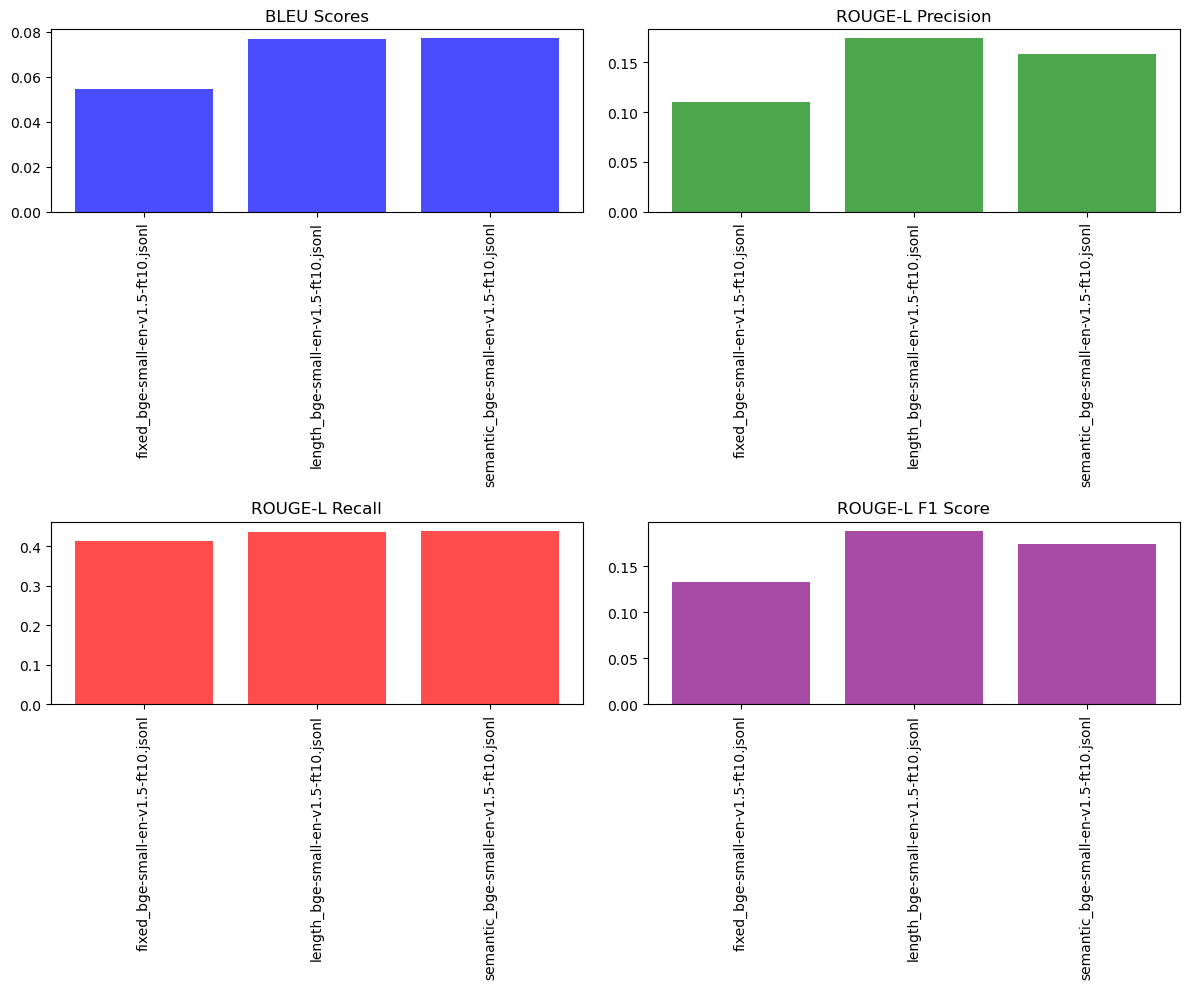

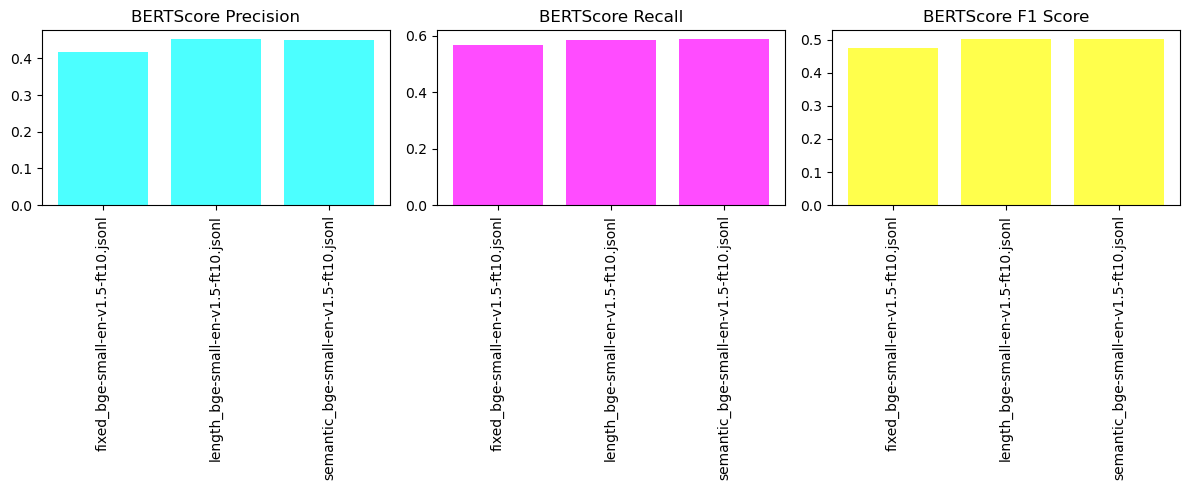

In [4]:
# 可视化上一步计算得到的指标结果文件
def visualize_results(results_path='../data/eval_results.json'):
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    strategies = [os.path.basename(result['result_path']) for result in results]
    bleu_scores = [result['BLEU'] for result in results]
    rouge_l_p_scores = [result['ROUGE-L P'] for result in results]
    rouge_l_r_scores = [result['ROUGE-L R'] for result in results]
    rouge_l_f_scores = [result['ROUGE-L F'] for result in results]
    bert_p_scores = [result['BERTScore P'] for result in results]
    bert_r_scores = [result['BERTScore R'] for result in results]
    bert_f_scores = [result['BERTScore F'] for result in results]
    
    x = range(len(strategies))
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    plt.bar(x, bleu_scores, color='b', alpha=0.7)
    plt.xticks(x, strategies, rotation='vertical')
    plt.title('BLEU Scores')
    
    plt.subplot(2, 2, 2)
    plt.bar(x, rouge_l_p_scores, color='g', alpha=0.7)
    plt.xticks(x, strategies, rotation='vertical')
    plt.title('ROUGE-L Precision')
    
    plt.subplot(2, 2, 3)
    plt.bar(x, rouge_l_r_scores, color='r', alpha=0.7)
    plt.xticks(x, strategies, rotation='vertical')
    plt.title('ROUGE-L Recall')
    
    plt.subplot(2, 2, 4)
    plt.bar(x, rouge_l_f_scores, color='purple', alpha=0.7)
    plt.xticks(x, strategies, rotation='vertical')
    plt.title('ROUGE-L F1 Score')
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 3, 1)
    plt.bar(x, bert_p_scores, color='cyan', alpha=0.7)
    plt.xticks(x, strategies, rotation='vertical')
    plt.title('BERTScore Precision')
    
    plt.subplot(1, 3, 2)
    plt.bar(x, bert_r_scores, color='magenta', alpha=0.7)
    plt.xticks(x, strategies, rotation='vertical')
    plt.title('BERTScore Recall')
    
    plt.subplot(1, 3, 3)
    plt.bar(x, bert_f_scores, color='yellow', alpha=0.7)
    plt.xticks(x, strategies, rotation='vertical')
    plt.title('BERTScore F1 Score')
    
    plt.tight_layout()
    plt.show()

# 可视化结果
visualize_results()

In [5]:
# 表格形式呈现上一步计算得到的指标结果文件
def visualize_results_table(results_path='../data/eval_results.json'):
    with open(results_path, 'r') as f:
        results = json.load(f)

    strategies = [os.path.basename(result['result_path']) for result in results]
    bleu_scores = [result['BLEU'] for result in results]
    rouge_l_p_scores = [result['ROUGE-L P'] for result in results]
    rouge_l_r_scores = [result['ROUGE-L R'] for result in results]
    rouge_l_f_scores = [result['ROUGE-L F'] for result in results]
    bert_p_scores = [result['BERTScore P'] for result in results]
    bert_r_scores = [result['BERTScore R'] for result in results]
    bert_f_scores = [result['BERTScore F'] for result in results]
    
    data = {
        'Strategy': strategies,
        'BLEU': bleu_scores,
        'ROUGE-L P': rouge_l_p_scores,
        'ROUGE-L R': rouge_l_r_scores,
        'ROUGE-L F': rouge_l_f_scores,
        'BERTScore P': bert_p_scores,
        'BERTScore R': bert_r_scores,
        'BERTScore F': bert_f_scores
    }
    df = pd.DataFrame(data)
    
    print(df)

visualize_results_table()


                                Strategy      BLEU  ROUGE-L P  ROUGE-L R  \
0     fixed_bge-small-en-v1.5-ft10.jsonl  0.054457   0.110053   0.414340   
1    length_bge-small-en-v1.5-ft10.jsonl  0.076475   0.174568   0.435454   
2  semantic_bge-small-en-v1.5-ft10.jsonl  0.077123   0.158904   0.439731   

   ROUGE-L F  BERTScore P  BERTScore R  BERTScore F  
0   0.132294     0.417206     0.566476     0.473961  
1   0.188543     0.453512     0.585480     0.502343  
2   0.173661     0.451181     0.589621     0.502550  


In [6]:
#